In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

So we want to optimize the way we pick bad terms i.e frequent polarizing terms that occur across topics
* Use Total Relevant Dataset for this not the sampled version
* 1. Optimizing Tf-IDF vectorizer (playing around with min_df and max_df)
* 2. Using Updated Stopwords List as the inbuilt stopword removal in the tfidfvectorizer is not capturing a lot of stopwords
* 3. Try using Feature Selection Techniques : 
    * Chi Squared 
    * Log Odds 
    * And compare with selection using model coefficients
* 4. Plot cosine sim (polar term) bert layer 12 vs Stance Detection Strength (lr weights, chi squared, log odds) to see which of the selected terms are truly polarizing
    * High Cosine Similarity would suggest less variance in the use of the polarizing term 
    * We need to find out how this cosine similarity varies according to different terms

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import torch
from torch import nn
from torch.utils.data import DataLoader
import transformers
import pandas as pd
import numpy as np
from transformers import BertModel, BertTokenizer
from Scripts.utils.bert_utils import load_tokenizer
from nltk.corpus import stopwords 
from Scripts.utils.preprocess_utils import preprocess_texts
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import random
import itertools
from Scripts.utils.bert_embeddings import load_bert_embeddings
from Scripts.utils.clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs
from Scripts.utils.general_utils import timer
import Scripts.utils.config as CONFIG
from attm_utils import load_pickle
from attm_metrics import calculate_scores, calculate_scores_single, get_accuracy_from_logits,print_res
from attm_model_utils import evaluate_mt, evaluate_st
from Scripts.utils.bert_utils import load_tokenizer
import  gc
import time
import pickle
import dill
from attm_utils import batch_text_gen, batch_gen_pred, tokenize_4bert_batch
from Scripts.utils.bert_utils import load_model, load_tokenizer, batch_text_gen
from tqdm import tqdm
import h5py
import random
from Scripts.utils.data_utils import load_data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk import word_tokenize

from Scripts.utils.preprocess_utils import preprocess_texts

....... Initializing Settings ..... 
Random_Seed Chosen : 15112


In [79]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = True

In [3]:
def save_obj(path,obj):
    """
    """
    with open(path,"wb") as wb:
        pickle.dump(obj,wb)

In [4]:
def count_words(X):
    XX = X.copy()
    XX.data /= XX.data
    return XX.sum(axis=0).A1 / X.shape[0]

def get_bad_terms(X, labels, vocab):
    """
    bad terms correlate with class label across all documents
    and are relatively frequent.
    We fit a simple logistic regression on all documents, 
    find top 100 terms per class, then select 100 most frequent from those.
    """
    clf = LogisticRegression(C=1, random_state=42, max_iter=1000)
    clf.fit(X, labels)
    c = clf.coef_[0]
    coef_sum = np.sum(c)
    bad_terms = []
    feats = np.array(vocab.get_feature_names())
    for i in np.argsort(c)[::-1][:200]:
        bad_terms.append((feats[i],c[i]))
    for i in np.argsort(c)[:200]:
        bad_terms.append((feats[i],c[i]))
    bad_terms = set(bad_terms)    
    word_count = count_words(X)
    f = sorted([(word_count[vocab.vocabulary_[w[0]]], w[0],w[1])  for w in bad_terms])[::-1][:200]
    return set(i[1] for i in f),f,coef_sum

def match_bad_terms(tokens_train, tokens_test, bad_terms):    
    all_toks = set()
    for t in tokens_train:
        all_toks.update(t)
    for t in tokens_test:
        all_toks.update(t)
    return sorted(list(bad_terms & all_toks))

def get_bad_term_embeddings(bad_terms):
    """
    """
    tokenizer = load_tokenizer()
    model= load_model()
    model.to(torch.device('cuda:0'))
    bad_term_embeds = []
    bad_term_tokens = []
    for b in bad_terms:
        bert_tok = tokenizer.encode_plus(b, add_special_tokens=False, max_length = 1, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
        
        token_id = bert_tok["input_ids"]
        token = tokenizer.convert_ids_to_tokens(token_id)
        bad_term_tokens.append(token)
        token_tensors = token_id.to(torch.device('cuda:0'))
        batch_out = model(token_tensors)
        batch_hidden_states = batch_out[2]
        batch_12_layer_tensor = batch_hidden_states[-1]
        token_embed = batch_12_layer_tensor.cpu()
        bad_term_embeds.append(token_embed)
    
    return bad_term_embeds,bad_term_tokens

# 1. Data Preperation

* Select only extreme partisan articles (-2,+2)
* To train classifier, balance dataset wrt to news source and partisan distribution

In [5]:
file_path = "../labeled_political_articles.pkl"

In [6]:
df = pd.DataFrame(list(pickle.load(open(file_path,"rb")).values()))

In [7]:
df.columns

Index(['article_id', 'url', 'title', 'text', 'source', 'source_partisan_score',
       'tweet_id', 'tweet_screen_name', 'tweet_created_at', 'tweet_text',
       'kws_label', 'cls_label'],
      dtype='object')

In [8]:
df["processed_title"] = preprocess_texts(df["title"].tolist())
df["processed_text"] = preprocess_texts(df["text"].tolist())

Running : select_first10
Running : to_lower
Running : remove_punc
Running : remove_small_words
Running : remove_spaces
Running : remove_non_alpha_numeric

Finished running 'preprocess_texts' in 0.1074 mins

Running : select_first10
Running : to_lower
Running : remove_punc
Running : remove_small_words
Running : remove_spaces
Running : remove_non_alpha_numeric

Finished running 'preprocess_texts' in 0.7565 mins



In [9]:
df["all_text"] = df["processed_title"] + df["processed_text"]

In [10]:
df.head(2)

,article_id,url,title,text,source,source_partisan_score,tweet_id,tweet_screen_name,tweet_created_at,tweet_text,kws_label,cls_label,processed_title,processed_text,all_text
0,2,https://www.foxnews.com/opinion/newt-gingrich-...,Newt Gingrich: Trump and the future – What his...,If you want to get a feel for the probable sha...,Fox News,1.0,1167180102599368715,Greg_DeFusco,Thu Aug 29 20:59:56 +0000 2019,Newt Gingrich: Trump and the future – What his...,"[abortion, us 2020 election]",[racism],newt gingrich trump and the future what histor...,if you want to get feel for the probable shape...,newt gingrich trump and the future what histor...
1,12,https://www.foxnews.com/politics/democratic-pa...,"Democratic Party embraces nonreligious voters,...",The Democratic National Committee (DNC) passed...,Fox News,1.0,1167179992545026056,deeahill,Thu Aug 29 20:59:30 +0000 2019,"Democratic Party embraces nonreligious voters,...","[abortion, LGBTQ, us 2020 election]",[],democratic party embraces nonreligious voters ...,the democratic national committee dnc passed r...,democratic party embraces nonreligious voters ...


In [11]:
df = df.loc[df["source_partisan_score"].isin([2.0,-2.0])]

In [12]:
df.shape

(63542, 15)

In [13]:
df["source"].value_counts()

Breitbart             9492
DailyCaller           6547
National Review       5062
Vox                   4986
AlterNet              4940
DailyWire             4657
DailyMail             4306
DailyBeast            3702
Slate                 3088
MSNBC                 2923
NYPost                2585
Mother Jones          2490
The Federalist        2398
BuzzFeed              2018
The Intercept         1449
HuffPo                1251
American Spectator    1006
DemocracyNow           642
Name: source, dtype: int64

In [14]:
df["binary_ps"] = df["source_partisan_score"].apply(lambda x: 1 if x>0 else 0)

In [15]:
df["binary_ps"].value_counts()

1    36053
0    27489
Name: binary_ps, dtype: int64

# 2. Sampling 

In [16]:
# balance by source
# balance by partisan Score

def balance_sampling(df,source_min=2000):
    """
    """
    df_s_list = []
    # balance sampling by source
    for grp,df_grp in df.groupby("source"):
        min_size = min([source_min,df_grp.shape[0]])
        df_grp = df_grp.sample(n=min_size,random_state=42)
        df_s_list.append(df_grp)
    
    df_o = pd.concat(df_s_list,axis=0).reset_index(drop=True)
    # balanced sampling by partisan score
    df_lib = df_o.loc[df_o["binary_ps"] == 0]
    df_cons = df_o.loc[df_o["binary_ps"] == 1]
    
    min_ps = min([df_lib.shape[0],df_cons.shape[0]])
    
    df_lib = df_lib.sample(n=min_ps,random_state=42)
    df_cons = df_cons.sample(n=min_ps,random_state=42)
    
    df_balanced = pd.concat([df_lib,df_cons]).reset_index(drop=True)
    df_balanced = df_balanced.sample(frac=1.0,random_state=42)
    
    return df_balanced

In [17]:
df_balanced = balance_sampling(df)

In [18]:
df_balanced["source"].value_counts()

National Review       2000
Breitbart             2000
DailyMail             2000
DailyWire             2000
NYPost                2000
DailyCaller           2000
The Federalist        2000
BuzzFeed              1744
DailyBeast            1736
Vox                   1731
AlterNet              1728
Mother Jones          1722
Slate                 1720
MSNBC                 1714
The Intercept         1268
HuffPo                1079
American Spectator    1006
DemocracyNow           564
Name: source, dtype: int64

In [19]:
df_balanced["binary_ps"].value_counts()

1    15006
0    15006
Name: binary_ps, dtype: int64

In [20]:
df_balanced.shape

(30012, 16)

In [184]:
for grp, df_grp in df_balanced.groupby("source"):
    print(grp)
    
    df_grp["said_exists"] = df_grp["all_text"].apply(lambda x: 1 if "said" in x else 0)
    said_count = sum(df_grp["said_exists"].tolist())
    print(said_count)
    print("\n")

AlterNet
711


American Spectator
212


Breitbart
1347


BuzzFeed
1240


DailyBeast
1014


DailyCaller
1258


DailyMail
1450


DailyWire
1215


DemocracyNow
191


HuffPo
529


MSNBC
1112


Mother Jones
748


NYPost
1405


National Review
773


Slate
600


The Federalist
660


The Intercept
579


Vox
717




# 3. Vocabulary Construction - TF-IDF Vectorizer

Noticed that the default sklearn tokenizer was not removing stop words 

In [28]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
ENGLISH_STOP_WORDS = set( stopwords.words('english') ).union( set(ENGLISH_STOP_WORDS) )

In [29]:
def tokenize(text):
    """
    """
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS]
    return tokens

In [30]:
tokenized_text = list(map(tokenize,[text for text in df_balanced["all_text"].tolist()]))

In [24]:
len(tokenized_text)

30012

In [25]:
tokenized_text[0]

['bug',
 'instagrams',
 'hashtags',
 'favoring',
 'donald',
 'trump',
 'technical',
 'error',
 'caused',
 'number',
 'hashtags',
 'related',
 'hashtags',
 'weve',
 'disabled',
 'feature',
 'investigate',
 'months',
 'key',
 'instagram',
 'feature',
 'algorithmically',
 'pushes',
 'users',
 'supposedly',
 'related',
 'content',
 'treating',
 'hashtags',
 'associated',
 'president',
 'donald',
 'trump',
 'democratic',
 'presidential',
 'nominee',
 'joe',
 'biden',
 'different',
 'ways',
 'searches',
 'biden',
 'return',
 'variety',
 'protrump',
 'messages',
 'searches',
 'trumprelated',
 'topics',
 'returned',
 'specific',
 'hashtags',
 'like',
 'maga',
 'trump',
 'means',
 'searches',
 'bidenrelated',
 'hashtags',
 'return',
 'countermessaging',
 'trump',
 'earlier',
 'week',
 'search',
 'instagram',
 'joebiden',
 'surfaced',
 'nearly',
 '390000',
 'posts',
 'tagged',
 'vice',
 'president',
 'related',
 'hashtags',
 'selected',
 'platform',
 'algorithm',
 'users',
 'searching',
 'instag

### Min Df = 500, max_df = 0.9

In [26]:
tfidf_vectorizer = TfidfVectorizer(min_df=500, binary=False, max_df=0.90, stop_words=ENGLISH_STOP_WORDS,max_features=None,tokenizer=tokenize)
X = tfidf_vectorizer.fit_transform(df_balanced["all_text"])
bad_terms_1,bad_term_coeffs,coef_sum = get_bad_terms(X, labels=df_balanced["binary_ps"], vocab=tfidf_vectorizer)

In [27]:
bad_terms_1

{'10',
 '2016',
 '2019',
 '2020',
 'access',
 'according',
 'accused',
 'actually',
 'added',
 'adding',
 'adviser',
 'agency',
 'ago',
 'alleged',
 'allies',
 'allow',
 'america',
 'american',
 'americans',
 'appears',
 'april',
 'article',
 'attorney',
 'barack',
 'based',
 'biden',
 'called',
 'came',
 'candidates',
 'care',
 'center',
 'chairman',
 'children',
 'china',
 'claimed',
 'claims',
 'close',
 'cnn',
 'comes',
 'company',
 'congress',
 'conservative',
 'conspiracy',
 'continued',
 'control',
 'conversation',
 'coronavirus',
 'corruption',
 'cut',
 'days',
 'democrat',
 'democrats',
 'described',
 'despite',
 'details',
 'dollars',
 'donald',
 'economy',
 'efforts',
 'elizabeth',
 'entire',
 'exactly',
 'failed',
 'far',
 'fbi',
 'financial',
 'following',
 'force',
 'forward',
 'future',
 'george',
 'going',
 'group',
 'happened',
 'helped',
 'hillary',
 'home',
 'house',
 'human',
 'hunter',
 'idea',
 'illegal',
 'immigrants',
 'impeachment',
 'important',
 'including',


In [28]:
bad_term_coeffs

[(0.5951619352259097, 'trump', -2.4164334070310267),
 (0.5950952952152473, 'president', 1.7126423318094766),
 (0.5245901639344263, 'said', 3.0329488223597405),
 (0.3720511795281887, 'donald', -5.099282750184661),
 (0.3178395308543249, 'house', -1.412797550616853),
 (0.24490203918432626, 'told', 0.9709548321615715),
 (0.24153671864587498, 'like', -1.4192941096573564),
 (0.2384379581500733, 'democrats', 3.7684493040357685),
 (0.2155804344928695, 'american', 1.154530955132845),
 (0.20518459282953486, 'according', 0.9665280335892964),
 (0.1876582700253232, 'joe', 1.0940420074795794),
 (0.186791949886712, 'biden', 1.5053563409944983),
 (0.18465946954551513, 'republican', -2.740696827908376),
 (0.18449286951885913, 'week', -1.4245922739954433),
 (0.18026122884179663, 'public', -1.7034095427293494),
 (0.16323470611755297, 'including', -1.2721475190407852),
 (0.1570371851259496, 'say', -1.5321965433691336),
 (0.15587098493935758, 'york', 1.5172448602202178),
 (0.15423830467812874, 'impeachment

In [29]:
coef_sum

-303.0504202220668

### Min Df = 500, max_df = 0.8

In [26]:
tfidf_vectorizer = TfidfVectorizer(min_df=500, binary=False, max_df=0.80, stop_words=ENGLISH_STOP_WORDS,max_features=None,tokenizer=tokenize)
X = tfidf_vectorizer.fit_transform(df_balanced["all_text"])
bad_terms_2,bad_term_coeffs_2,coef_sum = get_bad_terms(X, labels=df_balanced["binary_ps"], vocab=tfidf_vectorizer)

In [27]:
bad_terms_2

{'10',
 '2016',
 '2019',
 '2020',
 'access',
 'according',
 'accused',
 'actually',
 'added',
 'adding',
 'adviser',
 'agency',
 'ago',
 'alleged',
 'allies',
 'allow',
 'america',
 'american',
 'americans',
 'appears',
 'april',
 'article',
 'attorney',
 'barack',
 'based',
 'biden',
 'called',
 'came',
 'candidates',
 'care',
 'center',
 'chairman',
 'children',
 'china',
 'claimed',
 'claims',
 'close',
 'cnn',
 'comes',
 'company',
 'congress',
 'conservative',
 'conspiracy',
 'continued',
 'control',
 'conversation',
 'coronavirus',
 'corruption',
 'cut',
 'days',
 'democrat',
 'democrats',
 'described',
 'despite',
 'details',
 'dollars',
 'donald',
 'economy',
 'efforts',
 'elizabeth',
 'entire',
 'exactly',
 'failed',
 'far',
 'fbi',
 'financial',
 'following',
 'force',
 'forward',
 'future',
 'george',
 'going',
 'group',
 'happened',
 'helped',
 'hillary',
 'home',
 'house',
 'human',
 'hunter',
 'idea',
 'illegal',
 'immigrants',
 'impeachment',
 'important',
 'including',


In [28]:
bad_term_coeffs_2

[(0.5951619352259097, 'trump', -2.4164334070310267),
 (0.5950952952152473, 'president', 1.7126423318094766),
 (0.5245901639344263, 'said', 3.0329488223597405),
 (0.3720511795281887, 'donald', -5.099282750184661),
 (0.3178395308543249, 'house', -1.412797550616853),
 (0.24490203918432626, 'told', 0.9709548321615715),
 (0.24153671864587498, 'like', -1.4192941096573564),
 (0.2384379581500733, 'democrats', 3.7684493040357685),
 (0.2155804344928695, 'american', 1.154530955132845),
 (0.20518459282953486, 'according', 0.9665280335892964),
 (0.1876582700253232, 'joe', 1.0940420074795794),
 (0.186791949886712, 'biden', 1.5053563409944983),
 (0.18465946954551513, 'republican', -2.740696827908376),
 (0.18449286951885913, 'week', -1.4245922739954433),
 (0.18026122884179663, 'public', -1.7034095427293494),
 (0.16323470611755297, 'including', -1.2721475190407852),
 (0.1570371851259496, 'say', -1.5321965433691336),
 (0.15587098493935758, 'york', 1.5172448602202178),
 (0.15423830467812874, 'impeachment

In [185]:
for b in bad_term_coeffs_2:
    if "said" == b[1]:
        print(b)

(0.5245901639344263, 'said', 3.0329488223597405)


In [29]:
coef_sum

-303.0504202220668

### Min Df = 100, max_df = 0.7

In [34]:
tfidf_vectorizer = TfidfVectorizer(min_df=100, binary=False, max_df=0.70, stop_words=ENGLISH_STOP_WORDS,max_features=None,tokenizer=tokenize)
X = tfidf_vectorizer.fit_transform(df_balanced["all_text"])
bad_terms_3,bad_term_coeffs,coef_sum = get_bad_terms(X, labels=df_balanced["binary_ps"], vocab=tfidf_vectorizer)

In [35]:
bad_terms_3

{'11',
 '2019',
 '2020',
 'abc',
 'abortion',
 'access',
 'actually',
 'added',
 'admitted',
 'advocates',
 'afternoon',
 'agency',
 'ago',
 'alleged',
 'allegedly',
 'allies',
 'amendment',
 'america',
 'american',
 'amid',
 'amy',
 'article',
 'behavior',
 'biden',
 'biggest',
 'bit',
 'came',
 'campaigns',
 'center',
 'chair',
 'chairman',
 'china',
 'claimed',
 'claims',
 'climate',
 'close',
 'cnn',
 'company',
 'congress',
 'conservatives',
 'conspiracy',
 'continued',
 'controversial',
 'conversation',
 'corporate',
 'crimes',
 'days',
 'dca',
 'democracy',
 'democrat',
 'democrats',
 'described',
 'details',
 'disease',
 'donald',
 'effect',
 'efforts',
 'elizabeth',
 'ensure',
 'essentially',
 'experts',
 'facts',
 'failed',
 'familiar',
 'fellow',
 'foundation',
 'funds',
 'future',
 'giuliani',
 'going',
 'growing',
 'happened',
 'healthcare',
 'helped',
 'hillary',
 'hit',
 'home',
 'hunter',
 'idea',
 'illegal',
 'immigrant',
 'immigrants',
 'impeach',
 'impeachment',
 'im

In [36]:
bad_term_coeffs

[(0.5951619352259097, 'trump', -3.227033398915759),
 (0.5950952952152473, 'president', 2.194983042817855),
 (0.5245901639344263, 'said', 3.3437588662339044),
 (0.3720511795281887, 'donald', -5.8454836512711905),
 (0.24153671864587498, 'like', -1.7398372076312467),
 (0.2384379581500733, 'democrats', 4.590696572191489),
 (0.2155804344928695, 'american', 1.3276965992703413),
 (0.186791949886712, 'biden', 2.0373083407155383),
 (0.18465946954551513, 'republican', -2.715355616209723),
 (0.18449286951885913, 'week', -1.7944894497367927),
 (0.18026122884179663, 'public', -2.06634927037466),
 (0.17519658803145408, 'united', -1.4555378298851147),
 (0.16323470611755297, 'including', -1.5222909795266764),
 (0.1570371851259496, 'say', -1.6164906318541006),
 (0.15587098493935758, 'york', 1.4078815700224452),
 (0.15423830467812874, 'impeachment', 1.4087443953635073),
 (0.15010662401705985, 'going', 1.3077175976484003),
 (0.14240970278555246, 'think', 1.3439831648015836),
 (0.14200986272157803, 'offic

In [37]:
coef_sum

-485.4095366445222

### Min Df = 100, max_df = 0.6

In [38]:
tfidf_vectorizer = TfidfVectorizer(min_df=100, binary=False, max_df=0.60, stop_words=ENGLISH_STOP_WORDS,max_features=None,tokenizer=tokenize)
X = tfidf_vectorizer.fit_transform(df_balanced["all_text"])
bad_terms_4,bad_term_coeffs,coef_sum = get_bad_terms(X, labels=df_balanced["binary_ps"], vocab=tfidf_vectorizer)

In [39]:
bad_terms_4

{'11',
 '2019',
 '2020',
 'abc',
 'abortion',
 'access',
 'actually',
 'added',
 'admitted',
 'advocates',
 'afternoon',
 'agency',
 'ago',
 'alleged',
 'allegedly',
 'allies',
 'amendment',
 'america',
 'american',
 'amid',
 'amy',
 'article',
 'behavior',
 'biden',
 'biggest',
 'bit',
 'came',
 'campaigns',
 'center',
 'chair',
 'chairman',
 'china',
 'claimed',
 'claims',
 'climate',
 'close',
 'cnn',
 'company',
 'congress',
 'conservatives',
 'conspiracy',
 'continued',
 'controversial',
 'conversation',
 'corporate',
 'crimes',
 'days',
 'dca',
 'democracy',
 'democrat',
 'democrats',
 'described',
 'details',
 'disease',
 'donald',
 'effect',
 'efforts',
 'elizabeth',
 'ensure',
 'essentially',
 'experts',
 'facts',
 'failed',
 'familiar',
 'fellow',
 'foundation',
 'funds',
 'future',
 'giuliani',
 'going',
 'growing',
 'happened',
 'healthcare',
 'helped',
 'hillary',
 'hit',
 'home',
 'hunter',
 'idea',
 'illegal',
 'immigrant',
 'immigrants',
 'impeach',
 'impeachment',
 'im

In [40]:
bad_term_coeffs

[(0.5951619352259097, 'trump', -3.227033398915759),
 (0.5950952952152473, 'president', 2.194983042817855),
 (0.5245901639344263, 'said', 3.3437588662339044),
 (0.3720511795281887, 'donald', -5.8454836512711905),
 (0.24153671864587498, 'like', -1.7398372076312467),
 (0.2384379581500733, 'democrats', 4.590696572191489),
 (0.2155804344928695, 'american', 1.3276965992703413),
 (0.186791949886712, 'biden', 2.0373083407155383),
 (0.18465946954551513, 'republican', -2.715355616209723),
 (0.18449286951885913, 'week', -1.7944894497367927),
 (0.18026122884179663, 'public', -2.06634927037466),
 (0.17519658803145408, 'united', -1.4555378298851147),
 (0.16323470611755297, 'including', -1.5222909795266764),
 (0.1570371851259496, 'say', -1.6164906318541006),
 (0.15587098493935758, 'york', 1.4078815700224452),
 (0.15423830467812874, 'impeachment', 1.4087443953635073),
 (0.15010662401705985, 'going', 1.3077175976484003),
 (0.14240970278555246, 'think', 1.3439831648015836),
 (0.14200986272157803, 'offic

In [41]:
coef_sum

-485.4095366445222

### Similarity between Settings

In [42]:
set.intersection(*map(set,[bad_terms_1,bad_terms_2,bad_terms_3,bad_terms_4]))

{'2019',
 '2020',
 'access',
 'actually',
 'added',
 'agency',
 'ago',
 'alleged',
 'allies',
 'america',
 'american',
 'article',
 'biden',
 'came',
 'center',
 'chairman',
 'china',
 'claimed',
 'claims',
 'close',
 'cnn',
 'company',
 'congress',
 'conspiracy',
 'continued',
 'conversation',
 'days',
 'democrat',
 'democrats',
 'described',
 'details',
 'donald',
 'efforts',
 'elizabeth',
 'failed',
 'future',
 'going',
 'happened',
 'helped',
 'hillary',
 'home',
 'hunter',
 'idea',
 'illegal',
 'immigrants',
 'impeachment',
 'important',
 'including',
 'inquiry',
 'investigate',
 'key',
 'known',
 'later',
 'leading',
 'left',
 'liberal',
 'like',
 'likely',
 'major',
 'media',
 'medianame',
 'monday',
 'money',
 'months',
 'morning',
 'mr',
 'night',
 'office',
 'officials',
 'past',
 'pelosi',
 'politics',
 'president',
 'progressive',
 'public',
 'published',
 'questions',
 'race',
 'recently',
 'related',
 'reported',
 'republican',
 'republicans',
 'responded',
 'revealed',
 

### Using min_df of 500 and max_df of 0.8 seems to help pick good polarizing words but we still have a lot of noise , especially words that describe a moment in time , eg: monday, days, week ,weeks

# 4. Feature Selection - Chi Square 

In [48]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [49]:
tfidf_vectorizer = TfidfVectorizer(min_df=500, binary=False, max_df=0.80, stop_words=ENGLISH_STOP_WORDS,max_features=None,tokenizer=tokenize)
X = tfidf_vectorizer.fit_transform(df_balanced["all_text"])

vocab = tfidf_vectorizer.get_feature_names()

chi2_feats = SelectKBest(chi2, k=200)
feats = chi2_feats.fit_transform(X, df_balanced["binary_ps"])
feat_indices = chi2_feats.get_support(indices=True)

selected_words = np.array(vocab)[feat_indices]

In [75]:
scores_chi2 = chi2_feats.scores_

In [76]:
scores_chi2.shape

(1380,)

In [77]:
feat_indices.shape

(200,)

In [79]:
len(vocab)

1380

In [80]:
scores_chi2 = scores_chi2[feat_indices]

In [59]:
sum(scores_chi2)

1880.1919441446635

In [81]:
scores_chi2.shape

(200,)

In [46]:
selected_words

array(['2020', 'abc', 'abortion', 'access', 'act', 'adam', 'added',
       'administration', 'adviser', 'advocates', 'afternoon', 'agency',
       'agents', 'alleged', 'allegedly', 'allies', 'amendment', 'amy',
       'andrew', 'article', 'assault', 'assistance', 'biden', 'biggest',
       'bit', 'bloomberg', 'bush', 'campaigns', 'care', 'cases', 'center',
       'chair', 'chairman', 'change', 'children', 'china', 'chinese',
       'city', 'claims', 'climate', 'cnn', 'companies', 'company',
       'conditions', 'congress', 'congressional', 'conservative',
       'conspiracy', 'continued', 'controversial', 'corporate', 'courts',
       'data', 'days', 'dca', 'defense', 'democrat', 'democrats',
       'department', 'details', 'disease', 'documents', 'domestic',
       'donald', 'efforts', 'emails', 'experts', 'familiar', 'fbi',
       'federal', 'fellow', 'finance', 'financial', 'florida',
       'foundation', 'gay', 'giuliani', 'gop', 'government', 'group',
       'groups', 'gun', 'hall

In [181]:
for w in selected_words:
    print(w)

2020
abc
abortion
access
act
adam
added
administration
adviser
advocates
afternoon
agency
agents
alleged
allegedly
allies
amendment
amy
andrew
article
assault
assistance
biden
biggest
bit
bloomberg
bush
campaigns
care
cases
center
chair
chairman
change
children
china
chinese
city
claims
climate
cnn
companies
company
conditions
congress
congressional
conservative
conspiracy
continued
controversial
corporate
courts
data
days
dca
defense
democrat
democrats
department
details
disease
documents
domestic
donald
efforts
emails
experts
familiar
fbi
federal
fellow
finance
financial
florida
foundation
gay
giuliani
gop
government
group
groups
gun
hall
harris
health
healthcare
helped
hunter
idea
illegal
immigrant
immigrants
impeach
impeachment
important
including
increasingly
industry
influence
insurance
interference
investigations
investigators
iranian
james
joe
kamala
key
known
later
lawmakers
lawyers
left
legal
liberal
longtime
major
mayor
mcconnell
media
medianame
money
months
msnbc
mueller
na

In [47]:
len(set(bad_terms_2).intersection(selected_words))

80

### Chisquare test seems to also select topic keywords which are polarizing by themselves , eg: Abortion, immigrant, healthcare etc..

# 5. Feature Selection  - Log Odds using CLF coeff

Isn't log odds the same as using logistic regression coefficients ???

In [38]:
import statsmodels.api as sm

In [39]:
mod = sm.Logit(df_balanced["binary_ps"].values, X.todense())
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.484803
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                30012
Model:                          Logit   Df Residuals:                    28632
Method:                           MLE   Df Model:                         1379
Date:                Mon, 21 Jun 2021   Pseudo R-squ.:                  0.3006
Time:                        21:08:02   Log-Likelihood:                -14550.
converged:                       True   LL-Null:                       -20803.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.6114      0.646     -2.494      0.013      -2.878      -0.345
x2             0.5249      0.

In [40]:
type(res)

statsmodels.discrete.discrete_model.BinaryResultsWrapper

In [41]:
coeffs = res.params

In [42]:
sum(coeffs)

-35.16372591351051

In [43]:
top100_liberal = np.argsort(coeffs)[::-1][:100]
top100_conserv = np.argsort(coeffs)[:100]

In [44]:
logodds_scores = coeffs[np.concatenate([top100_liberal,top100_conserv])]

In [45]:
logodds_scores.shape

(200,)

In [50]:
log_odd_words = np.array(vocab)[np.concatenate([top100_liberal,top100_conserv])]

In [51]:
sorted(log_odd_words)

['11',
 '2008',
 '2019',
 '2020',
 'abc',
 'access',
 'adam',
 'added',
 'addition',
 'admitted',
 'adviser',
 'advocates',
 'afternoon',
 'alleged',
 'allegedly',
 'allies',
 'allowing',
 'amid',
 'amy',
 'andrew',
 'announcement',
 'annual',
 'arguing',
 'article',
 'attempting',
 'barack',
 'beat',
 'behavior',
 'biden',
 'biggest',
 'bit',
 'came',
 'campaigns',
 'caught',
 'center',
 'chair',
 'chairman',
 'china',
 'chuck',
 'citing',
 'claims',
 'cnn',
 'comes',
 'conditions',
 'congress',
 'conservatives',
 'conspiracy',
 'continued',
 'controversial',
 'conversation',
 'corporate',
 'coverage',
 'crimes',
 'days',
 'dca',
 'democrat',
 'democrats',
 'described',
 'details',
 'development',
 'direct',
 'donald',
 'efforts',
 'elizabeth',
 'ensure',
 'exchange',
 'experts',
 'facts',
 'failed',
 'familiar',
 'fellow',
 'finance',
 'foundation',
 'funds',
 'growing',
 'happened',
 'healthcare',
 'helped',
 'helping',
 'hillary',
 'hit',
 'human',
 'hunter',
 'idea',
 'illegal',
 

In [52]:
save_obj(path="Data_4_AttM/lr_coeff_based_terms.pkl",obj=bad_terms_2)
save_obj(path="Data_4_AttM/chisquare2_based_terms.pkl",obj=selected_words)
save_obj(path="Data_4_AttM/log_odds_based_terms.pkl",obj=log_odd_words)
save_obj(path="Data_4_AttM/coeffs_list.pkl",obj=bad_term_coeffs_2)
save_obj(path="Data_4_AttM/chisq2scores.pkl",obj=scores_chi2)
save_obj(path="Data_4_AttM/logodds.pkl",obj=logodds_scores)

In [21]:
bad_terms_2 = load_pickle("Data_4_AttM/lr_coeff_based_terms.pkl")
selected_words = load_pickle("Data_4_AttM/chisquare2_based_terms.pkl")
log_odd_words = load_pickle("Data_4_AttM/log_odds_based_terms.pkl")
bad_term_coeffs_2 = load_pickle("Data_4_AttM/coeffs_list.pkl")
scores_chi2 =load_pickle("Data_4_AttM/chisq2scores.pkl")
logodds_scores = load_pickle("Data_4_AttM/logodds.pkl")

In [68]:
lr_coeff_tups = [(a[1],a[0]) for a in bad_term_coeffs_2]
chi2_coeff_tups = [(a,b) for a,b in zip(selected_words,scores_chi2)]
logodds_coeff_tups = [(a,b) for a,b in zip(log_odd_words,logodds_scores)]

In [69]:
lr_coeff_tups

[('trump', 0.5951619352259097),
 ('president', 0.5950952952152473),
 ('said', 0.5245901639344263),
 ('donald', 0.3720511795281887),
 ('house', 0.3178395308543249),
 ('told', 0.24490203918432626),
 ('like', 0.24153671864587498),
 ('democrats', 0.2384379581500733),
 ('american', 0.2155804344928695),
 ('according', 0.20518459282953486),
 ('joe', 0.1876582700253232),
 ('biden', 0.186791949886712),
 ('republican', 0.18465946954551513),
 ('week', 0.18449286951885913),
 ('public', 0.18026122884179663),
 ('including', 0.16323470611755297),
 ('say', 0.1570371851259496),
 ('york', 0.15587098493935758),
 ('impeachment', 0.15423830467812874),
 ('going', 0.15010662401705985),
 ('2016', 0.14544182327069172),
 ('think', 0.14240970278555246),
 ('office', 0.14200986272157803),
 ('americans', 0.1374450219912035),
 ('officials', 0.13731174196987872),
 ('congress', 0.1367119818739171),
 ('america', 0.1329468212714914),
 ('vice', 0.1319805411168866),
 ('republicans', 0.13144742103158735),
 ('reported', 0.1

In [70]:
chi2_coeff_tups

[('2020', 4.5524002952318785),
 ('abc', 5.599460708253867),
 ('abortion', 24.964374768836553),
 ('access', 5.869725130601729),
 ('act', 4.226804201436982),
 ('adam', 9.684890330999373),
 ('added', 5.9377137046225235),
 ('administration', 12.254312135976003),
 ('adviser', 5.05912294027981),
 ('advocates', 8.54107145841277),
 ('afternoon', 5.067930875753588),
 ('agency', 9.292861527635711),
 ('agents', 4.299993811815286),
 ('alleged', 4.1003464819509805),
 ('allegedly', 6.5763654299376295),
 ('allies', 5.511611486314894),
 ('amendment', 5.508983636317691),
 ('amy', 9.862736273536722),
 ('andrew', 5.423342575601703),
 ('article', 3.733192535752774),
 ('assault', 4.916921352468739),
 ('assistance', 3.733281527740223),
 ('biden', 88.42541401851987),
 ('biggest', 4.545483572773643),
 ('bit', 6.078885729850795),
 ('bloomberg', 9.54589592072945),
 ('bush', 10.740626245920001),
 ('campaigns', 8.500766368724527),
 ('care', 8.64350505819427),
 ('cases', 3.9654121769756507),
 ('center', 6.39754992

In [71]:
logodds_coeff_tups

[('related', 14.915874449529259),
 ('dca', 8.159589223552077),
 ('stated', 7.590610405003189),
 ('taken', 7.561390699106776),
 ('illegal', 7.3274820967697245),
 ('continued', 7.1702303973669395),
 ('democrat', 6.776518106994155),
 ('regarding', 6.5980606984386885),
 ('revealed', 6.113372955692525),
 ('socialist', 5.867333044791576),
 ('media', 5.712669266718428),
 ('healthcare', 5.058825114275615),
 ('left', 5.034599044409389),
 ('democrats', 4.723174955931715),
 ('representative', 4.482577517894793),
 ('ivt', 4.435080222740235),
 ('terrorist', 4.378942462784406),
 ('said', 4.273596132764831),
 ('prior', 4.202595918967026),
 ('schiff', 4.1413053789720795),
 ('conservatives', 3.9123602178644328),
 ('important', 3.856808720868227),
 ('socalled', 3.793443010212215),
 ('probe', 3.7674770324609423),
 ('amid', 3.7421812471871023),
 ('politics', 3.730799768624429),
 ('failed', 3.729123874030804),
 ('fellow', 3.7196233958300553),
 ('watch', 3.701206785974252),
 ('cnn', 3.6531488382801207),
 ('

# Cosine(bert(w)) vs Feat Selection Scores

In [37]:
type(selected_words)

numpy.ndarray

In [54]:
type(bad_terms_2)

set

In [55]:
type(log_odd_words)

numpy.ndarray

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

In [23]:
def get_doc_map(terms,tokenized_text):
    """
    """
    term_map = defaultdict(list)
    for term in terms:
        for text_id,text in enumerate(tokenized_text):
            if term in text:
                term_map[term].append(text_id)
    
    return term_map

In [31]:
doc_map = get_doc_map(terms=set(list(bad_terms_2)+selected_words.tolist()+log_odd_words.tolist()),tokenized_text=tokenized_text)

In [32]:
doc_map = dict(doc_map)

In [33]:
doc_map_counts = {k:len(v) for k,v in doc_map.items()}

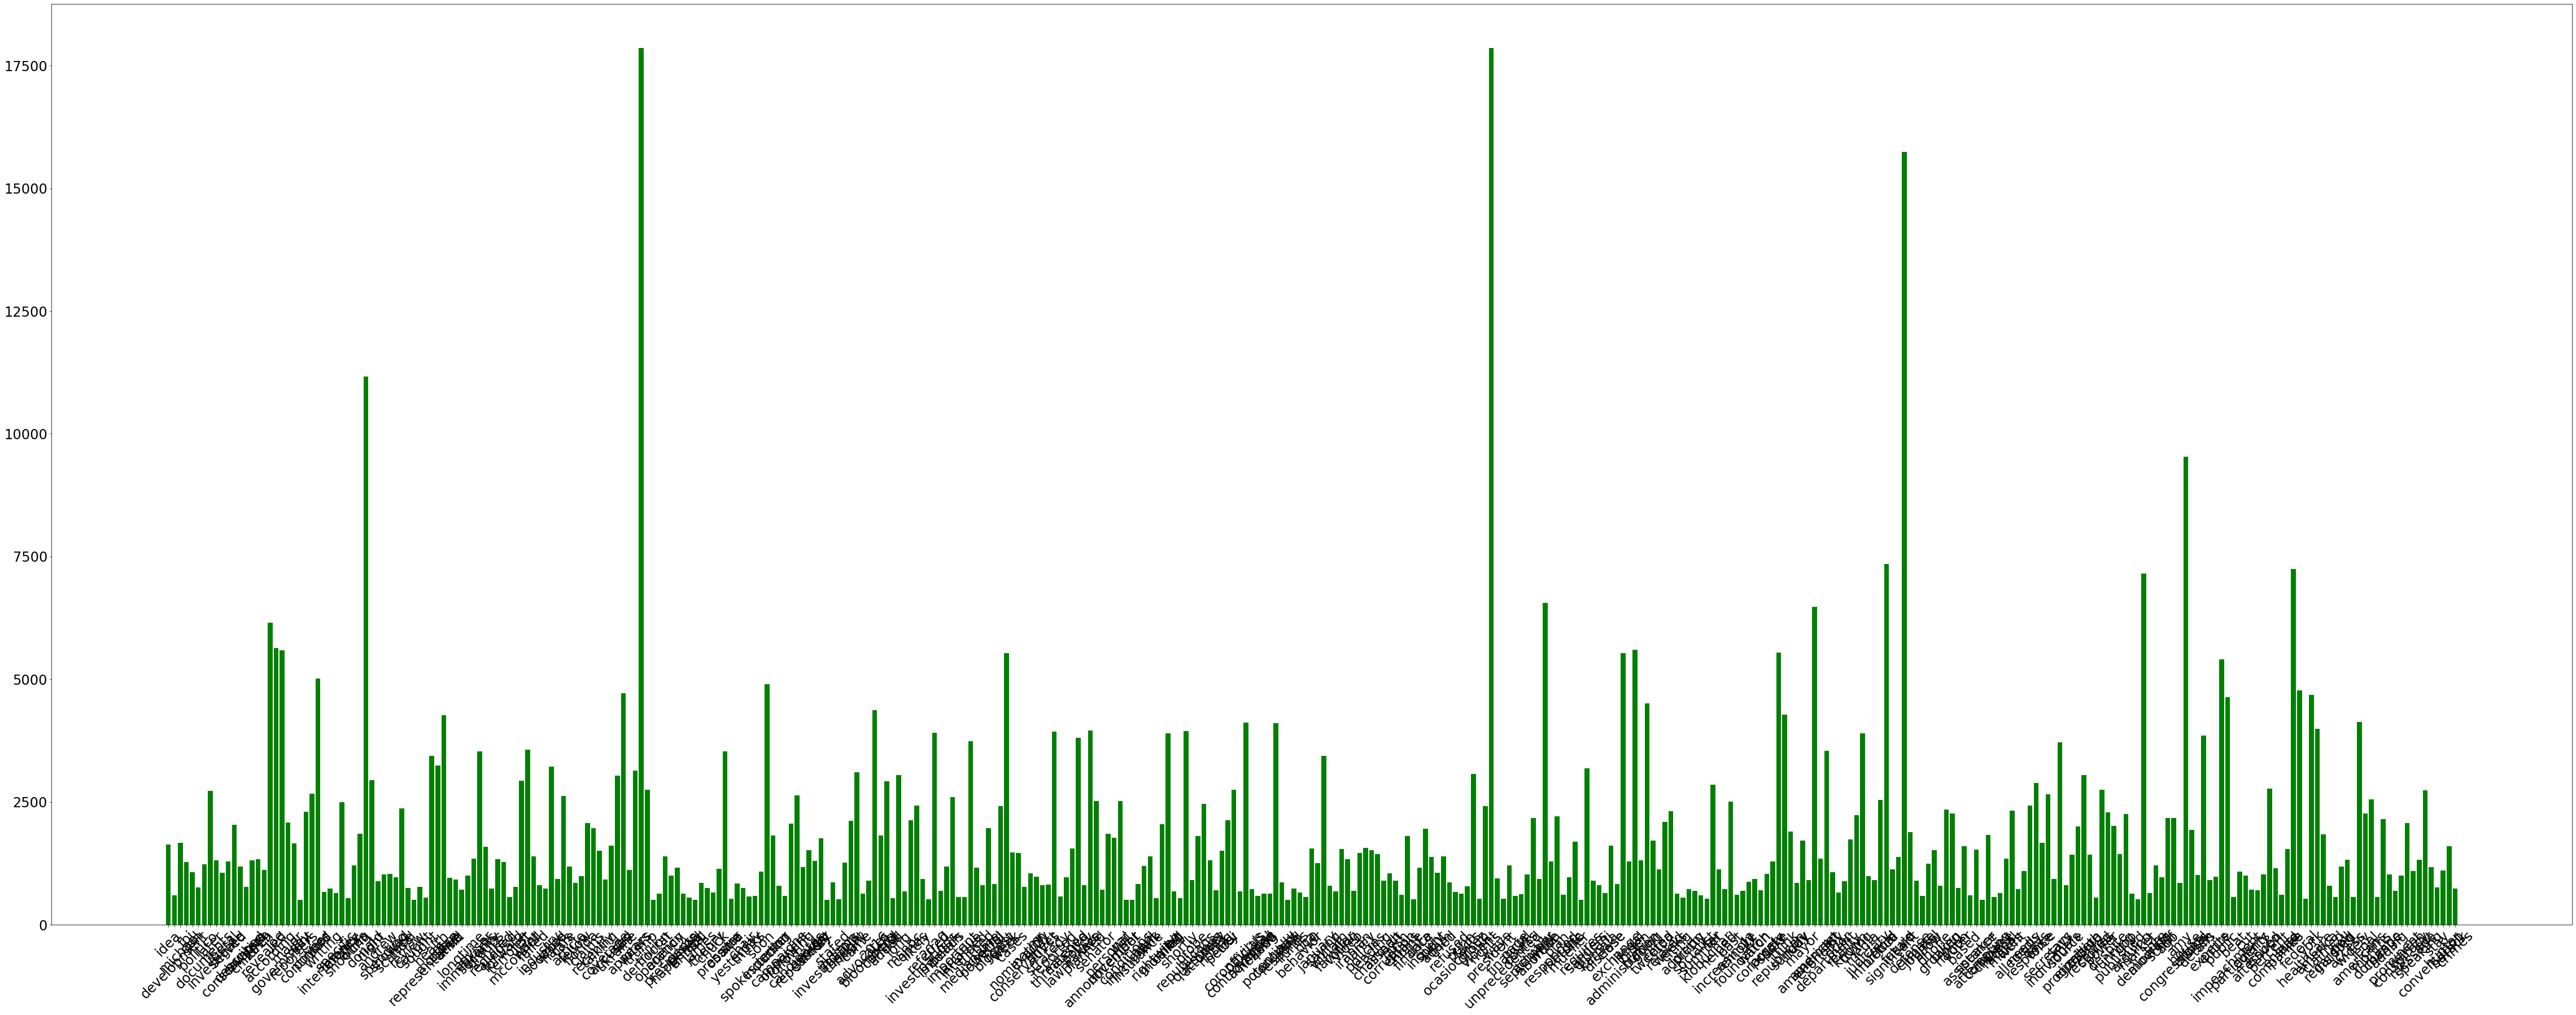

In [59]:
fig,ax = plt.subplots(1,1,figsize=(80,30))

ax.bar(list(doc_map_counts.keys()), doc_map_counts.values(), color='g')
ax.tick_params(axis='x', rotation=45)
plt.show()

In [60]:
len([pair for pair in itertools.combinations([i for i in range(50)],2)])

1225

In [61]:
len([pair for pair in itertools.combinations([i for i in range(100)],2)])

4950

In [162]:
def get_avg_cosine_sim(terms,df,doc_map,sample_size=100):
    """
    """
    # first get bert embed of the term in text after using text as input 
    # second get pairs of docs to find cosine sim betweem
    # third average the cosine sim scores
    # return the averaged cosine sim scores
    avg_cosine_sims = []
    final_terms = []
    tokenizer = load_tokenizer()
    model= load_model()
    model.to(torch.device('cuda:1'))
    
    for term in tqdm(terms,total=len(terms)):
        texts = df["all_text"].iloc[doc_map[term]].sample(n=sample_size,random_state=42).tolist()
        token_embeds = []

        for t in texts:
            bert_tokens = tokenizer.encode_plus(t, add_special_tokens=True, max_length = 300, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
            token_ids = bert_tokens["input_ids"]
            tokens = tokenizer.convert_ids_to_tokens(token_ids.flatten())
            term_index = -1
            try:
                term_index = tokens.index(term)
            except:
                continue

            if term_index != -1:

                token_tensors = token_ids.to(torch.device('cuda:1'))
                batch_out = model(token_tensors)
                batch_hidden_states = batch_out[2]
                batch_12_layer_tensor = batch_hidden_states[-1][:,term_index,:]
                token_embed = batch_12_layer_tensor.detach().cpu().numpy()
                token_embeds.append(token_embed)


        doc_pairs = [pair for pair in itertools.combinations([i for i in range(len(token_embeds))],2)]
        cosine_sims = [cosine_similarity(token_embeds[d[0]],token_embeds[d[1]]) for d in doc_pairs]
        if np.mean(cosine_sims) != np.nan:
            avg_cosine_sims.append(np.mean(cosine_sims))
            final_terms.append(term)
    
    model = None
    gc.collect()
    torch.cuda.empty_cache()
    
    return avg_cosine_sims,final_terms

In [163]:
avg_cosine_sims_lr_coeffs,lr_terms = get_avg_cosine_sim(terms=list(bad_terms_2),df=df_balanced,doc_map=doc_map,sample_size=50)

100%|██████████| 200/200 [04:07<00:00,  1.24s/it]


In [164]:
avg_cosine_sims_chi2,chi2_terms = get_avg_cosine_sim(terms=selected_words.tolist(),df=df_balanced,doc_map=doc_map,sample_size=50)

100%|██████████| 200/200 [03:58<00:00,  1.19s/it]


In [165]:
avg_cosine_sims_logodds,logodd_terms = get_avg_cosine_sim(terms=log_odd_words.tolist(),df=df_balanced,doc_map=doc_map,sample_size=50)

100%|██████████| 200/200 [03:59<00:00,  1.20s/it]


In [166]:
len(lr_terms)

200

In [167]:
len(chi2_terms)

200

In [168]:
len(logodd_terms)

200

In [169]:
avg_cosine_sims_lr_coeffs

[0.6793154,
 0.6758371,
 0.6603559,
 0.55760384,
 0.63184094,
 0.6167213,
 0.5975782,
 0.5662474,
 0.5580073,
 0.79071015,
 0.6147429,
 0.6741515,
 0.7141711,
 0.6064624,
 0.6885919,
 0.6842328,
 0.5647346,
 0.66389704,
 0.5353421,
 0.61583704,
 0.6157895,
 0.80868703,
 0.6189315,
 0.6555759,
 0.60492116,
 0.6494997,
 0.55914956,
 0.6212573,
 0.5535721,
 0.610245,
 0.6740595,
 0.6896378,
 0.5500273,
 0.68123424,
 0.5518728,
 0.6955345,
 0.62631637,
 0.62306774,
 0.6361603,
 0.6739685,
 0.5571269,
 0.6757474,
 0.6744034,
 0.6870852,
 nan,
 nan,
 0.46466994,
 0.60138726,
 0.585004,
 0.583955,
 0.73546535,
 0.5851849,
 0.68848443,
 0.609893,
 nan,
 0.6516889,
 0.677538,
 0.6820465,
 0.51559234,
 0.50699896,
 0.7442868,
 0.6925147,
 0.50714093,
 0.6527656,
 0.65603364,
 0.65164196,
 0.63902766,
 0.66302514,
 0.61926484,
 0.632538,
 0.6774975,
 0.5872718,
 0.6056671,
 0.60570735,
 0.59382343,
 0.7345265,
 0.6575196,
 0.6940944,
 0.7023605,
 0.54001844,
 0.64839494,
 0.47293496,
 0.64306223,

In [170]:
avg_cosine_sims_chi2

[0.672629,
 0.689524,
 0.7368379,
 0.64270693,
 0.55472404,
 0.7209869,
 0.5965945,
 0.6824313,
 0.6837171,
 0.6597171,
 0.70935714,
 0.60138726,
 0.65168566,
 0.6345655,
 0.6538394,
 0.6311074,
 0.6041315,
 0.6732226,
 0.6510166,
 0.6548056,
 0.58467776,
 0.65062934,
 nan,
 0.5997408,
 0.5300939,
 0.6539103,
 0.7226011,
 0.63489074,
 0.5709266,
 0.6168178,
 0.5577909,
 0.6314281,
 0.6885919,
 0.5913061,
 0.63200986,
 0.7223261,
 0.7052917,
 0.6123724,
 0.62605083,
 0.68648964,
 0.66302514,
 0.6832875,
 0.64306223,
 0.6221438,
 0.6896378,
 0.67263395,
 0.68667656,
 0.6955345,
 0.5904241,
 0.6286878,
 0.66937035,
 0.6805673,
 0.6530192,
 0.5916846,
 nan,
 0.5194703,
 0.6117885,
 0.6758371,
 0.6625114,
 0.6687789,
 0.6619343,
 0.67964244,
 0.5743312,
 0.80868703,
 0.6741515,
 0.69202447,
 0.69090486,
 0.60049987,
 0.6829142,
 0.6192348,
 0.6164485,
 0.64304715,
 0.6375527,
 0.6838684,
 0.63835186,
 0.6889179,
 nan,
 nan,
 0.6540214,
 0.5989476,
 0.65223944,
 0.6962435,
 0.6582981,
 0.704

In [171]:
avg_cosine_sims_logodds

[0.5589405,
 nan,
 0.6172076,
 0.54001844,
 0.62459725,
 0.5904241,
 0.6117885,
 0.64002395,
 0.6157895,
 0.6660062,
 0.6130334,
 0.66324776,
 0.47475725,
 0.6758371,
 0.5718778,
 nan,
 0.6923769,
 0.64901674,
 0.5922288,
 nan,
 0.6910886,
 0.63439226,
 nan,
 0.65901333,
 0.6453173,
 0.6516889,
 0.5697769,
 0.6164485,
 0.48207465,
 0.66302514,
 0.60570735,
 0.62605083,
 0.6885919,
 0.6510166,
 0.6689132,
 0.65895593,
 0.7660161,
 0.6345655,
 0.63835186,
 0.5330634,
 0.6309594,
 0.6849946,
 0.6413559,
 0.677841,
 0.5314303,
 0.582481,
 0.66389704,
 0.714714,
 0.6101695,
 nan,
 0.6669776,
 0.6538394,
 0.49202242,
 0.63656837,
 0.57171893,
 0.6820465,
 0.5589106,
 0.7223261,
 0.65476835,
 nan,
 0.6548056,
 nan,
 0.689108,
 0.7212356,
 0.5965945,
 nan,
 0.6922219,
 0.66964436,
 0.75737315,
 0.6018559,
 0.6530839,
 0.689524,
 0.5015295,
 0.6652891,
 0.59284174,
 0.5740639,
 0.65712637,
 0.68848443,
 nan,
 0.5766182,
 0.5405926,
 0.6929718,
 0.6449317,
 0.58825564,
 0.5179143,
 0.6212573,
 0

In [172]:
import math

def filter_lists(a,b):
    """
    """
    k,p = [],[]
    for i,j in zip(a,b):
        if not math.isnan(j):
            k.append(i)
            p.append(j)
    
    return k,p

In [173]:
lr_terms, avg_cosine_sims_lr_coeffs = filter_lists(lr_terms,avg_cosine_sims_lr_coeffs)

In [174]:
len(lr_terms)

193

In [175]:
chi2_terms, avg_cosine_sims_chi2 = filter_lists(chi2_terms,avg_cosine_sims_chi2)
logodd_terms, avg_cosine_sims_logodds = filter_lists(logodd_terms,avg_cosine_sims_logodds)

In [176]:
import plotly.express as px

def plot_cosine_sim_vs_selec_scores(terms,cosine_sims,scores):
    """
    """
    scores_ = []
    for t in terms:
        for s in scores:
            if s[0] == t:
                scores_.append(s[1])
    
#     fig,ax = plt.subplots(1,1,figsize=(20,20))
#     ax.scatter(scores_,cosine_sims)
#     for i, txt in enumerate(terms):
#         if cosine_sims[i] > 0.45:
#             ax.text( scores_[i]+.0003, cosine_sims[i]+.0003, txt, fontsize=12,rotation=0)
#     plt.show()
    
    df_ = pd.DataFrame()
    df_["Terms"] = terms
    df_["Average Cosine Similarity"] = cosine_sims
    df_["Score"] = scores_

    fig = px.scatter(df_, x="Score", y="Average Cosine Similarity", log_x=False,
                     hover_name="Terms",width=1000, height=900)
    
    fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
    
    fig.show()
    pass

In [177]:
# import plotly.express as px

# df_ = pd.DataFrame()
# df_["Terms"] = terns
# df_["Average Cosine Similarity"] = cosine_sims
# df_["Score"] = scores_

# fig = px.scatter(df_2007, x="gdpPercap", y="lifeExp", log_x=True,
#                  hover_name="country", hover_data=["continent", "pop"])

# fig.show()

In [178]:
plot_cosine_sim_vs_selec_scores(lr_terms,avg_cosine_sims_lr_coeffs,lr_coeff_tups)

In [179]:
plot_cosine_sim_vs_selec_scores(chi2_terms,avg_cosine_sims_chi2,chi2_coeff_tups)

In [182]:
len(doc_map["left"])

2930

In [ ]:
rerun with binary counts for chisquared